In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def _kmeans_single_lloyd(X, centers_init, max_iter=300):
    """A single run of k-means NMF.
    
    Args:
        X: The observations to cluster. ndarray of shape (n_features, n_samples).
        centers_init: The initial centers. ndarray of shape (n_features, n_clusters).
        max_iter: Maximum number of iterations of the k-means algorithm to run. int.
    
    Returns:
        F: label[i][j] indicate the i'th observation is closest to
          j'th centroid. ndarray of shape (n_features, n_clusters).
        inertia: The final value of the inertia criterion (sum of squared distances to
          the closest centroid for all observations in the training set). float.
        M: Centroids found at the last iteration of k-means. ndarray of 
          shape (n_clusters, n_features).
        n_iter: Number of iterations run. int.
    """
    n_samples = X.shape[1]
    n_clusters = centers_init.shape[1]
    M = centers_init
    for i in range(max_iter):
        F = np.zeros((n_samples, n_clusters), dtype=np.int32)
        for j in range(n_samples):
            tmp = np.tile(X[:, j], (n_clusters, 1)).T - M
            distances_square = sum(tmp ** 2)
            F[j, np.argmin(distances_square)] = 1
        M = X @ F @ np.linalg.inv(F.T @ F)
    inertia = np.linalg.norm(X - M @ F.T) ** 2
    
    return F, inertia, M, i+1

def _kmeans_single_coordinate_descent(X, centers_init, max_iter=300):
    """k-means optimized by coordinate descent.
    
    Args:
        X: The observations to cluster. ndarray of shape (n_features, n_samples).
        centers_init: The initial centers. ndarray of shape (n_features, n_clusters).
        max_iter: Maximum number of iterations of the k-means algorithm to run. int.
    
    Returns:
        F: label[i][j] indicate the i'th observation is closest to
          j'th centroid. ndarray of shape (n_features, n_clusters).
        inertia: The final value of the inertia criterion (sum of squared distances to
          the closest centroid for all observations in the training set). float.
        M: Centroids found at the last iteration of k-means. ndarray of 
          shape (n_clusters, n_features).
        n_iter: Number of iterations run. int.
    """
    n_samples = X.shape[1]
    n_clusters = centers_init.shape[1]
    M = centers_init
    # get initial F
    F = np.zeros((n_samples, n_clusters), dtype=np.int32)
    for j in range(n_samples):
        tmp = np.tile(X[:, j], (n_clusters, 1)).T - M
        distances_square = sum(tmp ** 2)
        F[j, np.argmin(distances_square)] = 1
    
    for i in range(max_iter):
        for j in range(n_samples):
            obj_with_F = np.zeros(n_clusters, dtype=np.int32)
            for k in range(n_clusters):
                F[j, :] = np.zeros(n_clusters)
                F[j, k] = 1
                obj_with_F[k] = np.trace(X @ F @ np.linalg.inv(F.T @ F) @ F.T @ X.T)
            F[j, :] = np.zeros(n_clusters, dtype=np.int32)
            F[j, np.argmax(obj_with_F)] = 1
    M = X @ F @ np.linalg.inv(F.T @ F)
    inertia = np.linalg.norm(X - M @ F.T) ** 2
    
    return F, inertia, M, i+1

class KMeans:
    """k-means clustering.
    
    Attributes:
        n_clusters: The number of clusters to form as well as the number of
        centroids to generate. int.
    """
    
    def __init__(self, n_clusters, max_iter=300):
        """Inits"""
        self.n_clusters = n_clusters
        self.max_iter = max_iter
    
    def _init_centroids(self, X):
        """Compute the initial centroids.
        
        Args:
            X: The input samples. ndarray of shape (n_features, n_samples).
        
        Returns:
            centers: ndarray of shape (n_featrues, n_clusters).
        """
        n_samples = X.shape[1]
        n_clusters = self.n_clusters
        
        seeds = np.random.permutation(n_samples)[:n_clusters]
        centers = X[:, seeds]
        
        return centers
    
    def fit(self, X):
        """Compute k-means clustering.
        
        Args:
            X: Training instances to cluster. array-like of shape (n_features, n_samples).
        
        Returns:
            self: Fitted estimator. object.
        """
        kmeans_single = _kmeans_single_coordinate_descent
        centers_init = self._init_centroids(X)
        F, inertia, M, n_iter_ = kmeans_single(X, centers_init, max_iter=self.max_iter)
        self.M_ = M
        self.F_ = F
        self.inertia_ = inertia
        self.n_iter_ = n_iter_
        
        return self

In [12]:
Data = np.loadtxt("Aggregation.txt")
X = Data[:, 0:-1].T
labels_true = Data[:, -1]

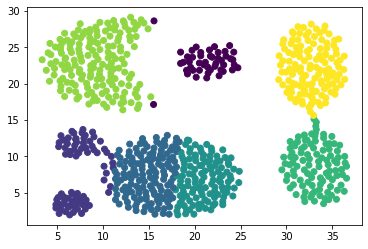

In [13]:
kmeans = KMeans(n_clusters=7).fit(X)
F = kmeans.F_
labels = np.nonzero(F)[1]
plt.scatter(X[0, :], X[1, :], c=labels)

In [21]:
kmeans.inertia_

10997.783230743682

In [14]:
kmeans.inertia_

10996.756054003887